<a href="https://colab.research.google.com/github/dkomlen/finance-ml/blob/main/loan_default_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

# XGB
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

#Libraries for Saving the Model
from pickle import dump
from pickle import load

#### 2.2 Loading the data

In [2]:
loans = pd.read_csv('https://github.com/tatsath/fin-ml/raw/master/Chapter%206%20-%20Sup.%20Learning%20-%20Classification%20models/CaseStudy2%20-%20Loan%20Default%20Probability/LoansData_sample.csv.gz', compression='gzip', encoding='utf-8')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
dataset = loans

In [4]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

In [6]:
dataset.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dataset.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [8]:
dataset.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,100000.000000,1.000000e+05,0.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,...,185.0,185.000000,185.0,185.000000,152.000000,185.000000,185.000000,1290.000000,1290.000000,1290.000000
mean,49999.500000,3.029995e+07,NaN,14886.930000,14886.930000,14883.910500,13.278073,437.331824,7.468924e+04,18.769787,...,3.0,110.335568,3.0,14.037838,323.495132,8046.616541,186.563135,4768.376357,47.720519,8.265116
std,28867.657797,4.763500e+06,NaN,8504.432514,8504.432514,8502.519174,4.390210,244.317648,5.809527e+04,8.539769,...,0.0,89.266601,0.0,9.657374,267.627244,5585.653253,168.552986,3703.963945,7.046587,8.263566
min,0.000000,5.716700e+04,NaN,1000.000000,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,...,3.0,1.470000,3.0,0.000000,4.410000,174.150000,0.040000,233.160000,0.550000,0.000000
25%,24999.750000,2.737015e+07,NaN,8000.000000,8000.000000,8000.000000,10.150000,261.640000,4.500000e+04,12.320000,...,3.0,23.760000,3.0,7.000000,63.885000,2465.360000,27.610000,1951.125000,45.000000,0.000000
50%,49999.500000,3.052556e+07,NaN,13050.000000,13050.000000,13050.000000,12.990000,380.180000,6.400000e+04,18.210000,...,3.0,96.580000,3.0,15.000000,281.580000,8049.850000,172.460000,3881.120000,45.040000,6.000000
75%,74999.250000,3.438201e+07,NaN,20000.000000,20000.000000,20000.000000,15.610000,573.320000,9.000000e+04,24.760000,...,3.0,164.750000,3.0,22.000000,481.492500,11968.940000,285.890000,6503.000000,50.000000,14.000000
max,99999.000000,3.809811e+07,NaN,35000.000000,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,...,3.0,382.340000,3.0,32.000000,1147.020000,21750.750000,757.420000,26751.740000,100.000000,36.000000


### 3. Data Preparation and Feature Selection

##### 3.1 Preparing the predicted variable

In [9]:
dataset['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

In [10]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [11]:
dataset['loan_status'].value_counts(dropna=False)

Fully Paid     69982
Charged Off    16156
Name: loan_status, dtype: int64

In [12]:
dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

In [13]:
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)

In [14]:
dataset['charged_off'].value_counts(normalize=True, dropna=False)

0    0.812441
1    0.187559
Name: charged_off, dtype: float64

### 3.2.1 Features elimination by significant mising values

In [50]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

In [51]:
missing_fractions.head(10)

bc_util                  0.012178
bc_open_to_buy           0.011563
revol_util               0.000511
loan_amnt                0.000000
funded_amnt              0.000000
charged_off              0.000000
num_actv_rev_tl          0.000000
mort_acc                 0.000000
mo_sin_rcnt_rev_tl_op    0.000000
mo_sin_old_rev_tl_op     0.000000
dtype: float64

In [52]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

In [53]:
drop_list

[]

In [54]:
len(drop_list)

0

In [55]:
dataset.drop(labels=drop_list, axis=1, inplace=True)

In [56]:
dataset.shape

(86138, 30)

### 3.2.2. Features elimination based on the intuitiveness

In [22]:
sorted(dataset.columns)

['Unnamed: 0',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'annual_inc',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'charged_off',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'debt_settlement_flag',
 'delinq_2yrs',
 'delinq_amnt',
 'disbursement_method',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'hardship_flag',
 'home_ownership',
 'id',
 'initial_list_status',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'last_pymnt_d',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl'

In [23]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

len(keep_list)

40

In [24]:
drop_list = [col for col in dataset.columns if col not in keep_list]

dataset.drop(labels=drop_list, axis=1, inplace=True)

In [25]:
dataset.shape

(86138, 39)

### 3.2.2. Features elimination based on correlation

In [26]:
correlation = dataset.corr()
correlation_chargeOff = abs(correlation['charged_off'])

In [27]:
correlation_chargeOff.sort_values(ascending=False)

charged_off              1.000000
last_pymnt_amnt          0.319081
int_rate                 0.282825
dti                      0.123108
fico_range_low           0.121892
fico_range_high          0.121891
acc_open_past_24mths     0.105989
bc_open_to_buy           0.080077
bc_util                  0.077744
avg_cur_bal              0.071977
num_actv_rev_tl          0.071185
revol_util               0.066188
loan_amnt                0.060818
funded_amnt              0.060818
mort_acc                 0.057858
annual_inc               0.050349
mo_sin_old_rev_tl_op     0.049426
mo_sin_rcnt_rev_tl_op    0.048839
open_acc                 0.039430
installment              0.032847
revol_bal                0.021714
pub_rec                  0.016023
pub_rec_bankruptcies     0.015815
total_acc                0.005804
id                       0.002221
Name: charged_off, dtype: float64

In [28]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))

In [29]:
drop_list_corr

['id', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']

In [30]:
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape

(86138, 34)

### 4. Feature Engineering and Exploratory Analysis

In [31]:
dataset.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
count,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,86094.000000,86138.000000,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000
mean,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,18.532747,692.462966,696.463024,11.746453,54.582777,4757.453184,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358,0.187559
std,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,8.538247,29.731549,29.731848,5.433122,23.515901,6466.767327,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598,0.390362
min,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,12.070000,670.000000,674.000000,8.000000,37.200000,358.522500,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000,0.000000
50%,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,17.950000,685.000000,689.000000,11.000000,54.900000,1241.230000,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000,0.000000
75%,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,24.500000,705.000000,709.000000,14.000000,72.500000,7303.205000,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000,0.000000
max,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,845.000000,850.000000,84.000000,180.300000,36234.440000,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000,1.000000


### 4.1 Feature Analysis and Exploration

#### 4.1.1. Analysing the categorical features

In [32]:
dataset[['emp_title','title','zip_code']].describe()

,emp_title,title,zip_code
count,81416,86138,86138
unique,32987,20,846
top,Teacher,Debt consolidation,750xx
freq,1576,52990,954


In [33]:
dataset.drop(['emp_title','title','zip_code'], axis=1, inplace=True)

In [34]:
dataset.shape

(86138, 31)

#### Feature Term

In [35]:
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

In [36]:
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141526
60    0.354356
Name: charged_off, dtype: float64

#### Feature Employment Length

In [37]:
dataset['emp_length'].value_counts()

10+ years    28177
2 years       7699
< 1 year      7060
3 years       6784
1 year        5482
4 years       5255
7 years       4582
5 years       4519
8 years       4319
6 years       4103
9 years       3441
Name: emp_length, dtype: int64

In [38]:
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [39]:
dataset['emp_length'].value_counts(dropna = False)

10 years    28177
2 years      7699
0 years      7060
3 years      6784
1 year       5482
4 years      5255
NaN          4717
7 years      4582
5 years      4519
8 years      4319
6 years      4103
9 years      3441
Name: emp_length, dtype: int64

In [40]:
dataset['emp_length'] = dataset['emp_length'].apply(lambda s: s if pd.isnull(s) else np.int8(s.split()[0]))

In [41]:
dataset['emp_length'].value_counts(dropna = False)

10.0    28177
2.0      7699
0.0      7060
3.0      6784
1.0      5482
4.0      5255
NaN      4717
7.0      4582
5.0      4519
8.0      4319
6.0      4103
9.0      3441
Name: emp_length, dtype: int64

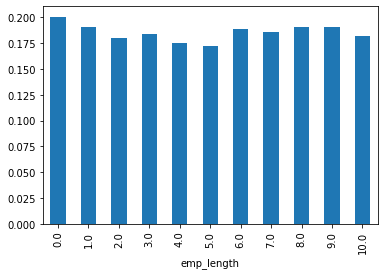

In [42]:
charge_off_rates = dataset.groupby('emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
charge_off_rates.plot(kind='bar');

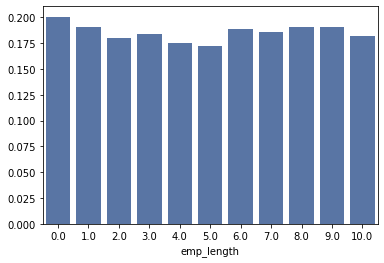

In [43]:
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

In [44]:
dataset.drop(['emp_length'], axis=1, inplace=True)

### Feature : Subgrade

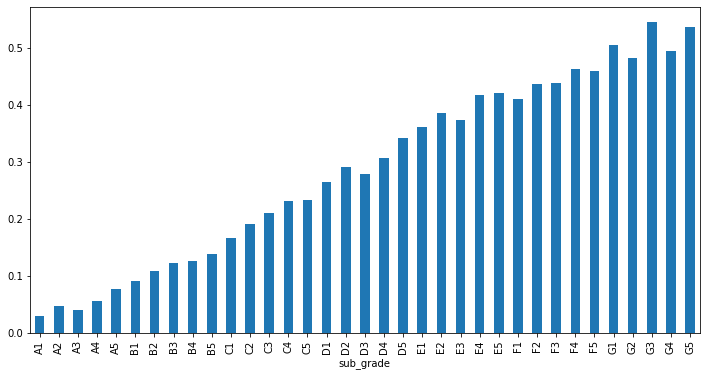

In [45]:
charge_off_rates = dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
charge_off_rates.plot(kind='bar', figsize=(12,6));

In [46]:
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:]))

#### 4.1.2. Analysing the continuous features

##### Feature : Annual Income

In [47]:
dataset[['annual_inc']].describe()

,annual_inc
count,8.613800e+04
mean,7.384311e+04
std,5.929352e+04
min,4.000000e+03
25%,4.500000e+04
50%,6.247372e+04
75%,9.000000e+04
max,7.500000e+06


In [48]:
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset.drop('annual_inc', axis=1, inplace=True)

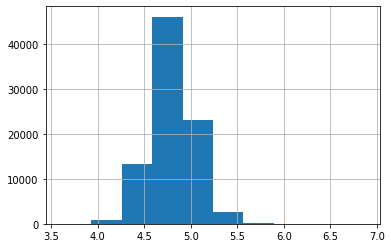

In [49]:
dataset['log_annual_inc'].hist();

#### FICO Scores

In [59]:
dataset[['fico_range_low', 'fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [62]:
dataset['fico_score'] = (dataset['fico_range_low'] + dataset['fico_range_high']) / 2
dataset.drop(['fico_range_low', 'fico_range_high'], axis=1, inplace=True)

In [63]:
dataset['charged_off'].value_counts()

0    69982
1    16156
Name: charged_off, dtype: int64

In [64]:
dataset.dtypes

loan_amnt                float64
funded_amnt              float64
term                        int8
int_rate                 float64
installment              float64
grade                     object
sub_grade                 object
home_ownership            object
verification_status       object
purpose                   object
addr_state                object
dti                      float64
earliest_cr_line           int64
open_acc                 float64
revol_util               float64
initial_list_status       object
last_pymnt_amnt          float64
application_type          object
acc_open_past_24mths     float64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_rev_tl_op    float64
mort_acc                 float64
num_actv_rev_tl          float64
charged_off                 int8
log_annual_inc           float64
fico_score               float64
dtype: object

### 4.2. Encoding Categorical Data

In [65]:
from sklearn.preprocessing import LabelEncoder

In [68]:
categorical_cols = dataset.columns[dataset.dtypes == object].tolist()

In [78]:
le = LabelEncoder()
dataset[categorical_cols] = dataset[categorical_cols].apply(le.fit_transform)
dataset[categorical_cols].head(10)

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
0,2,10,3,1,2,40,1,0
1,0,2,1,0,1,4,1,0
2,3,15,3,1,1,21,1,0
4,2,12,3,1,2,3,0,0
5,2,12,3,1,2,26,0,0
6,1,9,1,1,3,20,0,0
7,1,8,2,2,2,40,1,0
8,2,13,3,1,1,42,0,0
9,1,8,3,0,2,18,0,0
10,1,9,3,2,2,19,0,0


In [84]:
dataset[categorical_cols].nunique()

grade                   7
sub_grade              35
home_ownership          4
verification_status     3
purpose                13
addr_state             46
initial_list_status     2
application_type        1
dtype: int64

In [86]:
dataset.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,15000.0,15000.0,60,12.39,336.64,2,10,3,1,2,...,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,0,4.892100,752.0
1,10400.0,10400.0,36,6.99,321.08,0,2,1,0,1,...,9536.0,7599.0,41.5,290.0,1.0,1.0,9.0,1,4.763435,712.0
2,21425.0,21425.0,60,15.59,516.36,3,15,3,1,1,...,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,0,4.804827,687.0
4,7650.0,7650.0,36,13.66,260.20,2,12,3,1,2,...,5857.0,332.0,93.2,148.0,8.0,0.0,4.0,1,4.698979,687.0
5,9600.0,9600.0,36,13.66,326.53,2,12,3,1,2,...,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,0,4.838855,682.0


In [87]:
dataset.dtypes

loan_amnt                float64
funded_amnt              float64
term                        int8
int_rate                 float64
installment              float64
grade                      int64
sub_grade                  int64
home_ownership             int64
verification_status        int64
purpose                    int64
addr_state                 int64
dti                      float64
earliest_cr_line           int64
open_acc                 float64
revol_util               float64
initial_list_status        int64
last_pymnt_amnt          float64
application_type           int64
acc_open_past_24mths     float64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_rev_tl_op    float64
mort_acc                 float64
num_actv_rev_tl          float64
charged_off                 int8
log_annual_inc           float64
fico_score               float64
dtype: object

In [89]:
dataset.shape

(86138, 29)

#### 4.3 Sampling Data

In [90]:
dataset['charged_off'].value_counts()

0    69982
1    16156
Name: charged_off, dtype: int64

In [93]:
loanstatus_0 = dataset[dataset['charged_off']==0].sample(5500)
loanstatus_1 = dataset[dataset['charged_off']==1].sample(5500)
dataset = pd.concat([loanstatus_0, loanstatus_1])

In [97]:
dataset = dataset.sample(frac=1)

In [104]:
dataset = dataset.reset_index(drop=True)

In [105]:
dataset.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,18000.0,18000.0,36,7.12,556.78,0,2,2,0,2,...,707.0,5417.0,46.4,340.0,29.0,0.0,4.0,0,4.643463,732.0
1,14400.0,14400.0,60,11.67,317.93,1,8,1,2,2,...,15455.0,2100.0,95.2,194.0,15.0,4.0,13.0,1,5.086363,702.0
2,21650.0,21650.0,36,15.61,756.99,3,15,3,2,1,...,46991.0,3384.0,91.7,127.0,82.0,0.0,2.0,0,4.778158,687.0
3,21625.0,21625.0,60,16.99,537.33,3,17,1,2,2,...,9298.0,11585.0,48.0,103.0,4.0,1.0,13.0,1,4.792399,677.0
4,12625.0,12625.0,36,16.99,450.06,3,17,3,1,1,...,13669.0,1009.0,88.7,82.0,2.0,3.0,6.0,1,4.778158,662.0


In [112]:
dataset.dtypes.sort_index()

acc_open_past_24mths     float64
addr_state                 int64
application_type           int64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
charged_off                 int8
dti                      float64
earliest_cr_line           int64
fico_score               float64
funded_amnt              float64
grade                      int64
home_ownership             int64
initial_list_status        int64
installment              float64
int_rate                 float64
last_pymnt_amnt          float64
loan_amnt                float64
log_annual_inc           float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_rev_tl_op    float64
mort_acc                 float64
num_actv_rev_tl          float64
open_acc                 float64
purpose                    int64
revol_util               float64
sub_grade                  int64
term                        int8
verification_status        int64
dtype: object

In [144]:
test_dataset = pd.DataFrame(dataset)

In [141]:
test_dataset['revol_util'] = test_dataset['revol_util'].fillna(test_dataset['revol_util'].mode()[0])

In [155]:
dataset.fillna(dataset.mean(), inplace=True)

In [156]:
dataset.isna().any()

loan_amnt                False
funded_amnt              False
term                     False
int_rate                 False
installment              False
grade                    False
sub_grade                False
home_ownership           False
verification_status      False
purpose                  False
addr_state               False
dti                      False
earliest_cr_line         False
open_acc                 False
revol_util               False
initial_list_status      False
last_pymnt_amnt          False
application_type         False
acc_open_past_24mths     False
avg_cur_bal              False
bc_open_to_buy           False
bc_util                  False
mo_sin_old_rev_tl_op     False
mo_sin_rcnt_rev_tl_op    False
mort_acc                 False
num_actv_rev_tl          False
charged_off              False
log_annual_inc           False
fico_score               False
dtype: bool

#### 5. Evaluate Algorithms and Models

##### 5.1. Train Test Split

In [157]:
Y = dataset['charged_off']
X = dataset.loc[:, dataset.columns != 'charged_ff']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

##### 5.2. Test Options and Evaluation Metrics

In [158]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

#### 5.3. Compare Models and Algorithms

##### Classification Models

In [161]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
# models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

models.append(('XGB', XGBClassifier()))

In [162]:
estimators = []
estimators.append(LogisticRegression(max_iter=10000))
estimators.append(XGBClassifier(max_depth=2, n_estimators=500, learning_rate=0.1))
estimators.append(RandomForestClassifier(random_state=2))

models.append(('VOTE', VotingClassifier(estimators)))

#### K-folds cross validation

In [167]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.898294 (0.010666)
LDA: 0.899463 (0.010215)
KNN: 0.815780 (0.015603)
CART: 1.000000 (0.000000)
NB: 0.975588 (0.003285)
AB: 1.000000 (0.000000)
GBM: 1.000000 (0.000000)
RF: 1.000000 (0.000000)
ET: 1.000000 (0.000000)
XGB: 1.000000 (0.000000)
VOTE: nan (nan)


In [165]:
X_train.describe()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
count,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,...,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000
mean,14456.176136,14456.176136,42.834545,13.966705,436.581573,2.051591,12.216136,1.991364,0.997386,2.410341,...,11853.607273,8366.079955,65.008713,180.845909,12.021818,1.647500,5.945455,0.499773,4.784571,691.511364
std,8302.417797,8302.417797,10.831963,4.539569,246.322863,1.401807,6.916193,0.944496,0.762138,1.925043,...,14270.776182,13826.519859,26.488276,92.760160,15.358007,2.056663,3.307821,0.500028,0.231768,27.671705
min,1000.000000,1000.000000,36.000000,6.030000,30.440000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,3.778224,662.000000
25%,8000.000000,8000.000000,36.000000,10.990000,258.710000,1.000000,7.000000,1.000000,0.000000,2.000000,...,2858.000000,989.750000,46.700000,115.000000,3.000000,0.000000,4.000000,0.000000,4.633479,672.000000
50%,12425.000000,12425.000000,36.000000,13.660000,379.760000,2.000000,12.000000,2.000000,1.000000,2.000000,...,6230.000000,3534.500000,67.800000,165.000000,7.000000,1.000000,5.000000,0.000000,4.778158,682.000000
75%,20000.000000,20000.000000,60.000000,16.490000,570.887500,3.000000,17.000000,3.000000,2.000000,2.000000,...,15958.500000,9359.500000,88.500000,229.000000,14.000000,3.000000,8.000000,1.000000,4.929424,702.000000
max,35000.000000,35000.000000,60.000000,26.060000,1318.450000,6.000000,34.000000,3.000000,2.000000,11.000000,...,223342.000000,224525.000000,157.000000,716.000000,297.000000,23.000000,30.000000,1.000000,5.811576,842.000000
